In [1]:
from matplotlib import pyplot as plt

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import ngon, circles, corners, checkerboard
from survae.layer import BijectiveLayer, AbsoluteUnit
from survae.layer import OrthonormalLayer

Device: cpu


# Training Shenanigans

In [2]:
model_generators = [
    lambda: SurVAE(
        [
            BijectiveLayer(2, [64] * 5),
            OrthonormalLayer(2),
        ] * 10,
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(1 / 2),
        ] + [
            BijectiveLayer(2, [64] * 5),
            OrthonormalLayer(2),
        ] * 10,
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(1 / 2, learn_q=True),
        ] + [
            BijectiveLayer(2, [64] * 5),
            OrthonormalLayer(2),
        ] * 10,
    )
]

dataset_functions = [ngon, circles, corners, checkerboard]

In [3]:
# Train the datasets
models = {}
batch_size = 1_000
test_size = 10_000
epochs = 100
log_count = epochs // 10

# Iterate over datasets and create heatm aps
for i, dataset_function in enumerate(dataset_functions):
    for j, model_generator in enumerate(model_generators):
        model = model_generator()
        print(f"[{i * len(model_generators) + j + 1}/{len(dataset_functions) * len(model_generators)}] ", end="")
        results = model.train(
            dataset_function, batch_size=batch_size, test_size=test_size,
            epochs=epochs, lr=0.001, log_count=log_count
        )

        models[i, j] = (model, results)

[1/12] Starting training... done in 4.57 seconds
[2/12] Starting training... done in 3.77 seconds
[3/12] Starting training... done in 4.01 seconds
[4/12] Starting training... done in 3.55 seconds
[5/12] Starting training... done in 3.71 seconds
[6/12] Starting training... done in 4.09 seconds
[7/12] Starting training... done in 4.73 seconds
[8/12] Starting training... done in 4.39 seconds
[9/12] Starting training... done in 4.45 seconds
[10/12] Starting training... done in 6.47 seconds
[11/12] Starting training... done in 5.83 seconds
[12/12] Starting training... done in 5.30 seconds


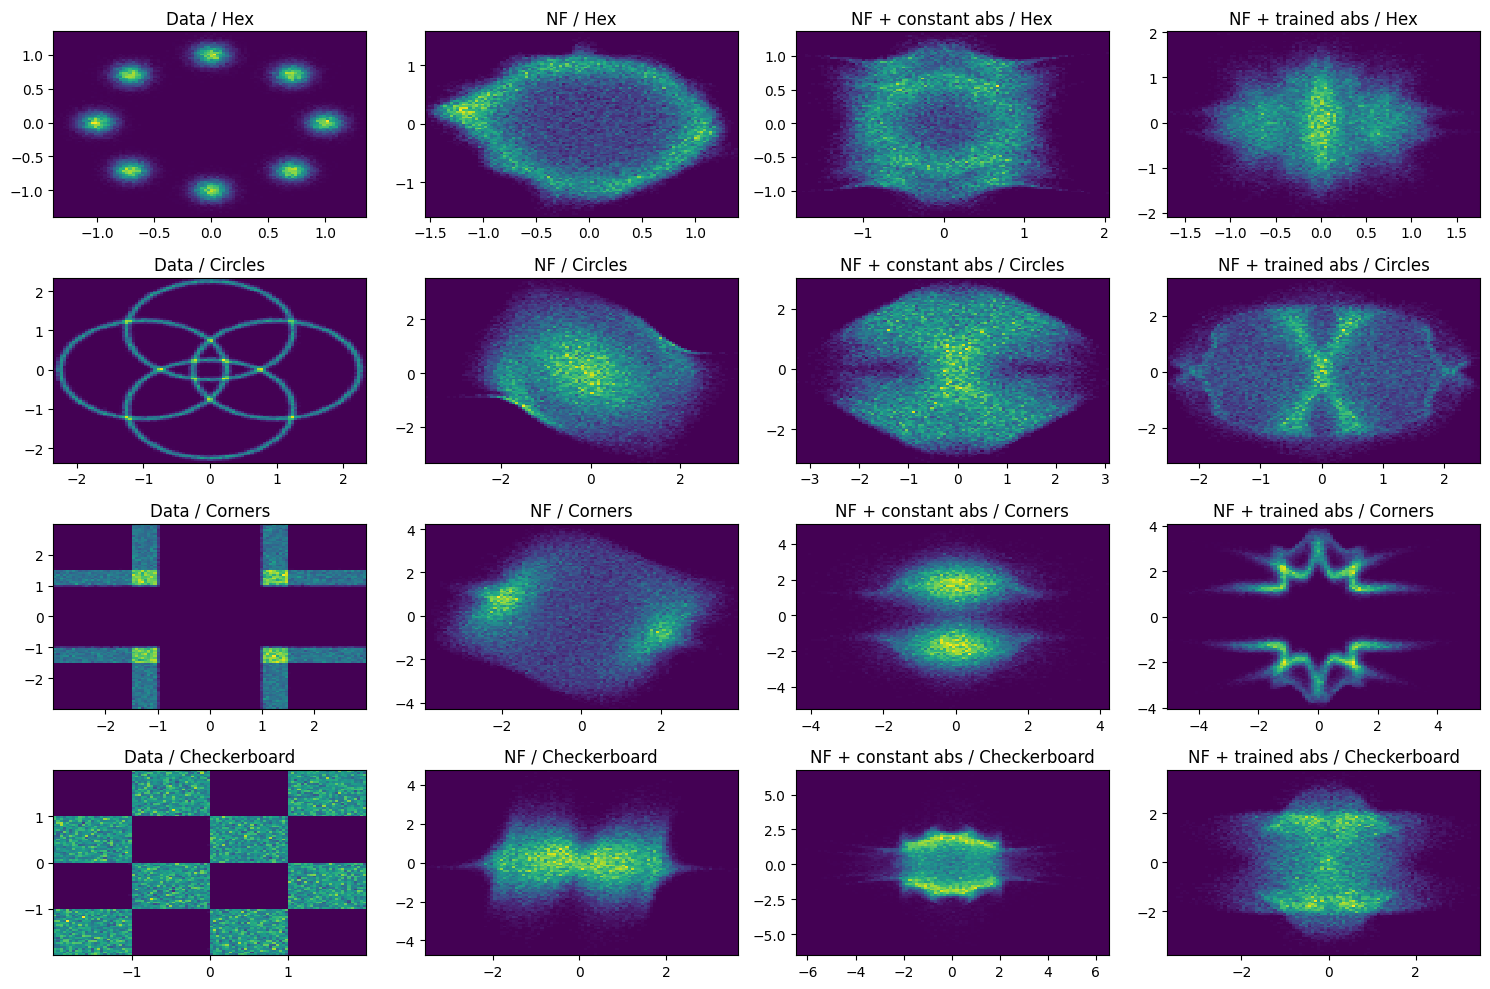

In [4]:
# Define dataset names
model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
dataset_names = ['Hex', 'Circles', 'Corners', 'Checkerboard']

sample_count = 100_000
bins = 100

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(sample_count).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=bins)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

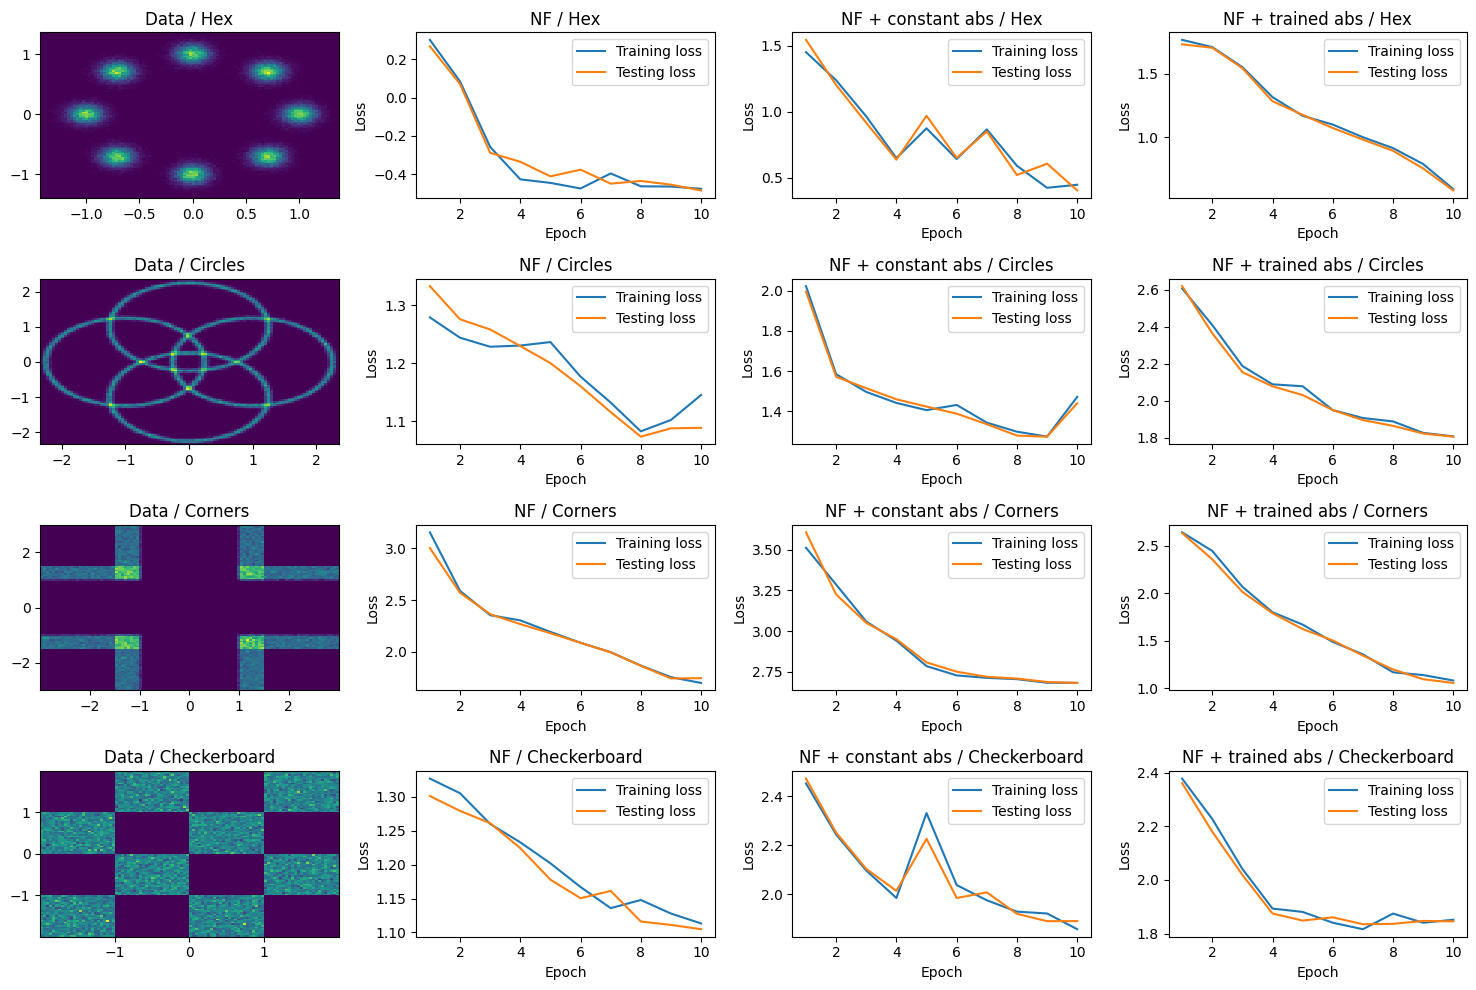

In [5]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epochs = range(1, len(training_loss) + 1)

        axs[i, j + 1].plot(epochs, training_loss, label='Training loss')
        axs[i, j + 1].plot(epochs, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

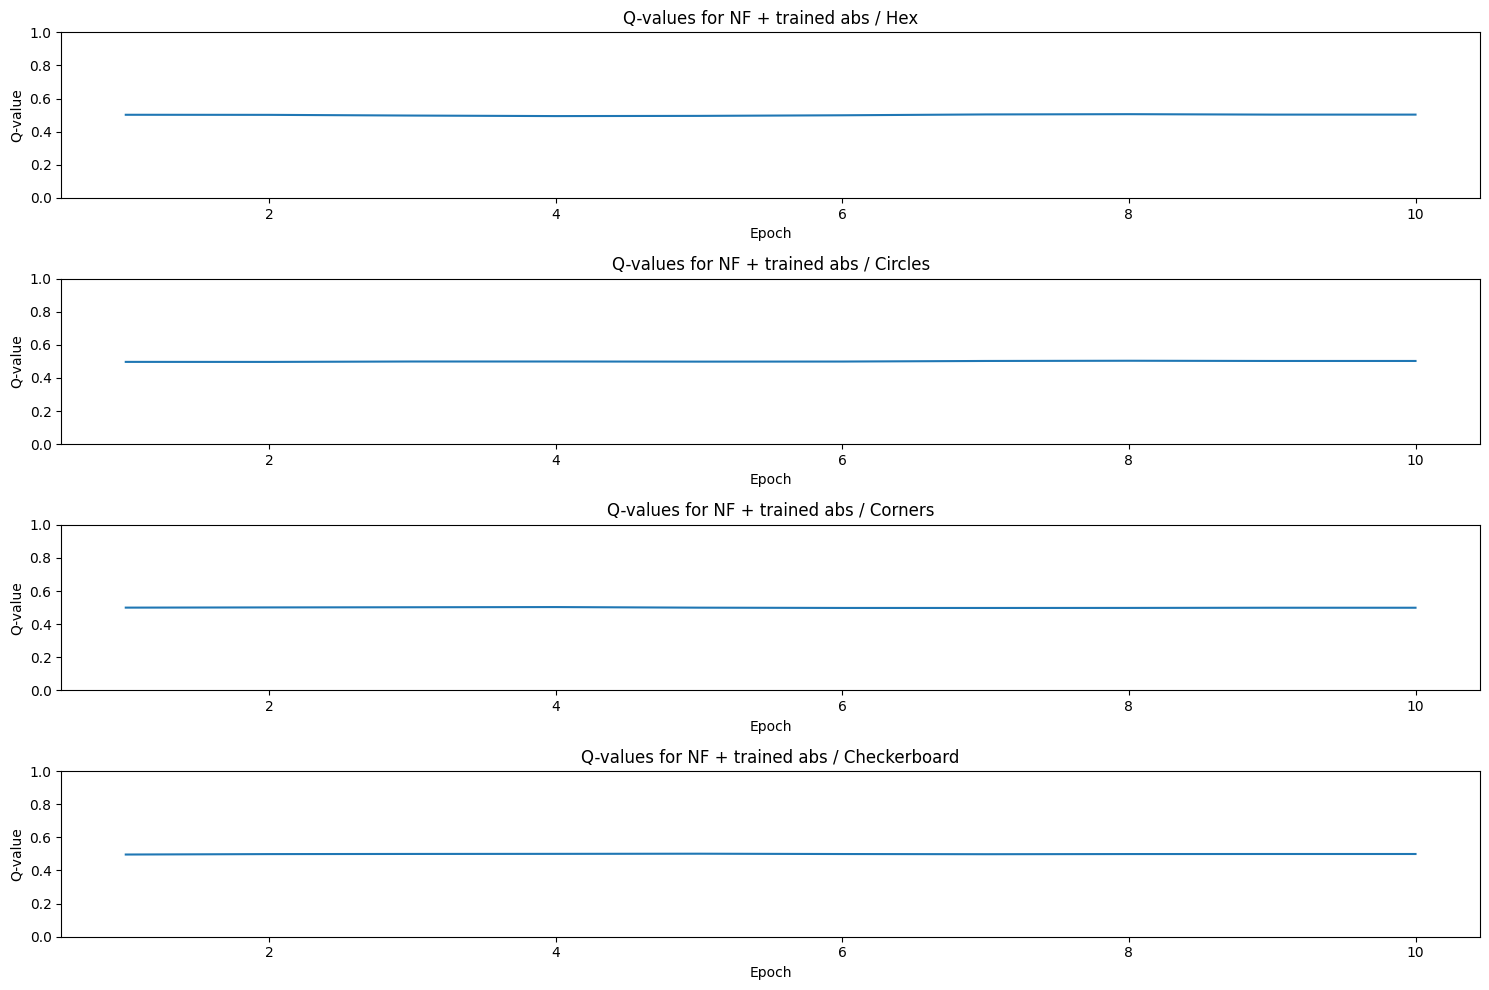

In [6]:
# TODO: go through the models and plot the values
fig, axs = plt.subplots(len(dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(model_names) - 1]

    qs = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        qs.append(model.layers[0].q.item())

    epochs = range(1, len(qs) + 1)

    axs[i].plot(epochs, qs)
    axs[i].set_title(f'Q-values for {model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')
    axs[i].set_ylim([0, 1])

# Adjust layout
plt.tight_layout()
plt.show()

# Calibration

In [10]:
model = SurVAE(
    [
        AbsoluteUnit(1 / 2, learn_q=True),
    ] + [
        BijectiveLayer(2, [64] * 5),
        OrthonormalLayer(2),
    ] * 10,
)

model.train(ngon, batch_size=1000, epochs=100, lr=0.001);

Starting training... done in 5.21 seconds


In [11]:
X_test = model.sample(100)
cs = calc_cs(model, X_test, 50)

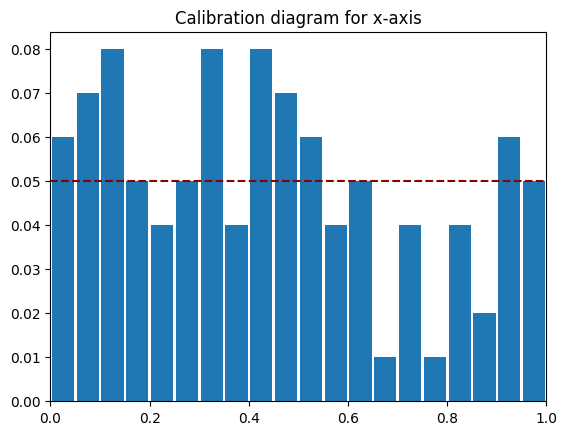

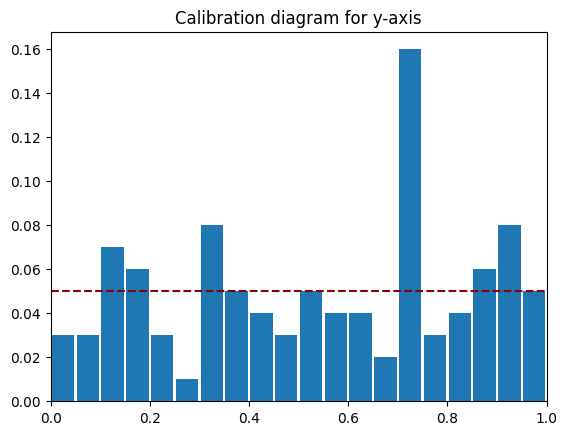

In [12]:
plot_histogram(cs[0], 20, "Calibration diagram for x-axis")
plot_histogram(cs[1], 20, "Calibration diagram for y-axis")

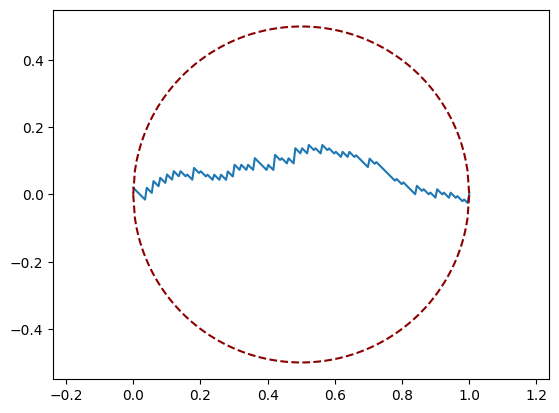

In [13]:
plot_cdf(cs[0])